# Onderzoeksvraag 3

In hoeverre is het mogelijk om logische clusters van consumenten (bijv. AMT_INCOME_TOTAL, DAYS_EMPLOYED, CNT_FAM_MEMBERS) en hun leningen te vinden (bijv. AMT_CREDIT, AMT_ANNUITY, AMT_GOODS_PRICE)? Denk aan consumenten met (te)veel, weinig of geen leningen.

Daarvoor moeten wij een diepere duik in de data doen en een goed model te kiezen

### Diepere duik in de data

Voordat we daadwerkelijk beginnen. Bekijken we eerst naar de data om te zien wat intressante features kunnen zijn.

### In de volgende Features zijn we geintreseerd.
|Kolom naam|Omschrijving|Meetwaarde|
|-|-|-|
| AMT_CREDIT | Dit is de hoeveelheid dat de client als lening heeft gekregen. |Interval|
| AMT_GOODS_PRICE | Dit is de hoeveelheid dat wordt uitgeleend voor het product/investering van de client. |Interval|
| AMT_ANNUITY | Dit is hoeveel er maandelijks in termijnen terugbetaald moet worden door de klant. |Interval|
| AMT_INCOME_TOTAL | Het inkomen van de client wat er maandelijks wordt verdiend. |Interval|
| NAME_CONTRACT_TYPE | Geeft aan of het contract Cash is of Maandelijkse afschrift. |Nominaal|
| FLAG_OWN_REALTY | Geeft aan of een client een huis/flat bezit (In verband met minder/meer lenen). |Nominaal|
| FLAG_OWN_CAR | Geeft aan of iemand eigenaar is van een eigen auto. |Nominaal|
| CODE_GENDER | Geeft het gender aan van de client (interessant om te kijken of daar een verschil in zit). |Nominaal|
| DAYS_BIRTH | Hoeveel dagen de client is wanneer die op de dag van aanmelding. |Interval|
| NAME_EDUCATION_TYPE | Wat het hoogste behaalde schoolniveau is van de client. |Nominaal|

### Nu kunnen we met een voor bedacht plan kijken of de boven genoemde features ook echt zo intressant zijn.

##### Eerst importeren we de nodige libarys

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from scipy.spatial import Voronoi, voronoi_plot_2d
import warnings
warnings.filterwarnings("ignore")
from sklearn.impute import SimpleImputer

Vervolgens importeren we de data en gaan we kijken wat er in zit.

In [2]:
app_data = pd.read_csv("src/application_data.csv",sep=",", encoding='cp1252', index_col=0)
app_data.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


### Hier maken we een overzicht van de Centrummaten en Spreidings maten

De describe() functie van pandas geeft ons een mooi overzicht.

In [3]:
app_data.describe()

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,-4986.120328,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,3522.886321,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,-24672.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,-7479.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,-4504.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,-2010.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


Als we boven in de 2 tabbelen kijken zien we dat we best wel wat features hebben om mee te spelen. 

###### Dus is het dan belanrijk om te kijken welke het meeste invloed op elkaar hebben. Dit doen we hier onder.

### Data Cleaning / Transforming
Voordat we een colleratie matrix Kunnen maken is het belangrijk om Bepaalde features te transformen, En op te schonen aangezien deze daar in niet gebruikt kunnen worden. Dit word vooral gedaan om er mee te spelen. Dit heeft mischien we helemaal geen correlatie

#### Transforming

Alle strings worden met een int vervangen om op die manier categorieën toch te gebruiken in ons correlatie matrix

In [4]:
cols = ['NAME_EDUCATION_TYPE', 'CODE_GENDER', 
        'FLAG_OWN_REALTY', 'NAME_CONTRACT_TYPE', 
        'NAME_HOUSING_TYPE', 'FLAG_OWN_CAR']

# use sklearn's preprocessing labelencoder to transform the columns to corresponding ints
encoder = LabelEncoder()

# encode all columns
for col in cols:
    app_data[col] = encoder.fit_transform(app_data[col])

#### Data Cleaning

Hier voor moeten wat meer dingen gedaan worden. We Moeten kijken naar missende waardes en bepalen of we die er uit willen halen of willen aanvullen waar mogelijk.

De eerste stap die we nemen is kijken hoe vaak de nan in onze dataset voorkomt.

#### Hier kijken we hoeveel procent van elke kolom hebben nans in de data zitten.

In [5]:
# We kijken the nan count voor elke column in de app_data
nan_count = app_data.isnull().sum()

for column in app_data:
    nan_count_for_column = nan_count[column]
    total_count = len(app_data)
    nan_percentage = (nan_count_for_column / total_count) * 100
    # Laat alleen columns zien met nan values
    if nan_count_for_column > 0:
        print(f"For column: {column}, we have: {nan_count_for_column} nan values, which is {nan_percentage:.2f}% of the total.")

For column: AMT_ANNUITY, we have: 12 nan values, which is 0.00% of the total.
For column: AMT_GOODS_PRICE, we have: 278 nan values, which is 0.09% of the total.
For column: NAME_TYPE_SUITE, we have: 1292 nan values, which is 0.42% of the total.
For column: OWN_CAR_AGE, we have: 202929 nan values, which is 65.99% of the total.
For column: OCCUPATION_TYPE, we have: 96391 nan values, which is 31.35% of the total.
For column: CNT_FAM_MEMBERS, we have: 2 nan values, which is 0.00% of the total.
For column: EXT_SOURCE_1, we have: 173378 nan values, which is 56.38% of the total.
For column: EXT_SOURCE_2, we have: 660 nan values, which is 0.21% of the total.
For column: EXT_SOURCE_3, we have: 60965 nan values, which is 19.83% of the total.
For column: APARTMENTS_AVG, we have: 156061 nan values, which is 50.75% of the total.
For column: BASEMENTAREA_AVG, we have: 179943 nan values, which is 58.52% of the total.
For column: YEARS_BEGINEXPLUATATION_AVG, we have: 150007 nan values, which is 48.78%

#### Hier onder maken we een correlatie matrix van sommige Features. Om inzicht te krijgen welke features samen goede clusters zouden kunnen vormen

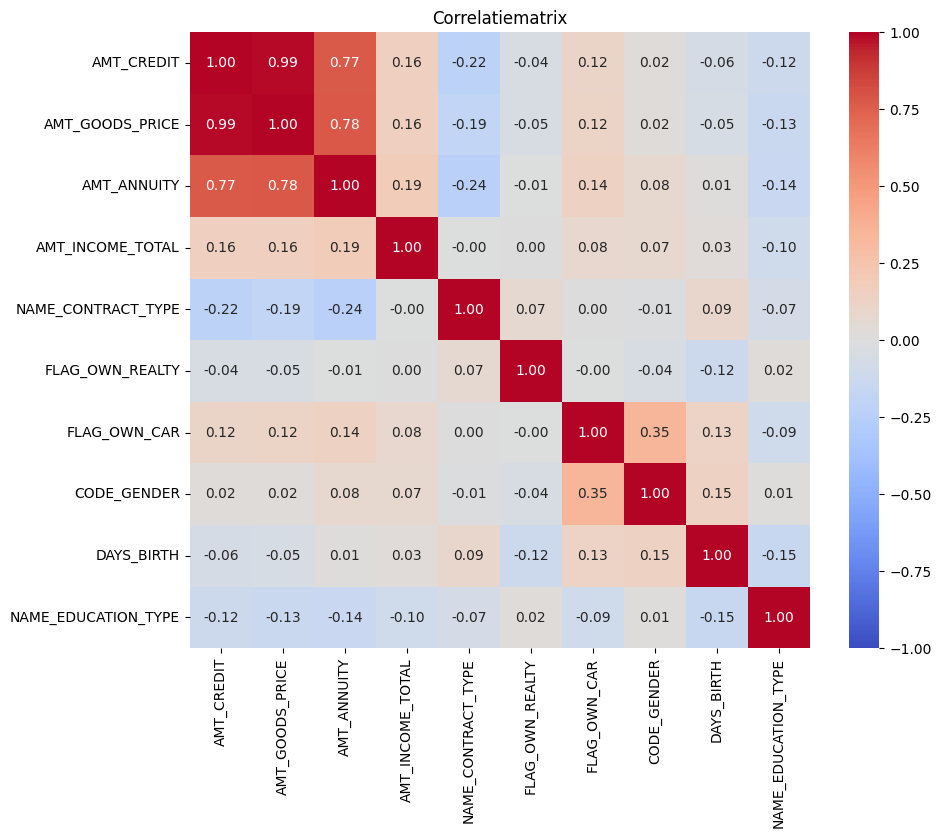

In [6]:
correlation_matrix = app_data[['AMT_CREDIT','AMT_GOODS_PRICE','AMT_ANNUITY','AMT_INCOME_TOTAL','NAME_CONTRACT_TYPE','FLAG_OWN_REALTY','FLAG_OWN_CAR','CODE_GENDER','DAYS_BIRTH','NAME_EDUCATION_TYPE']].corr()


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
plt.title('Correlatiematrix')
plt.show()

### Pairplots voor visualisatie

We maken van de intressante features uit de correlatie matrix pairplots om te kijken hoe dat er uit ziet.

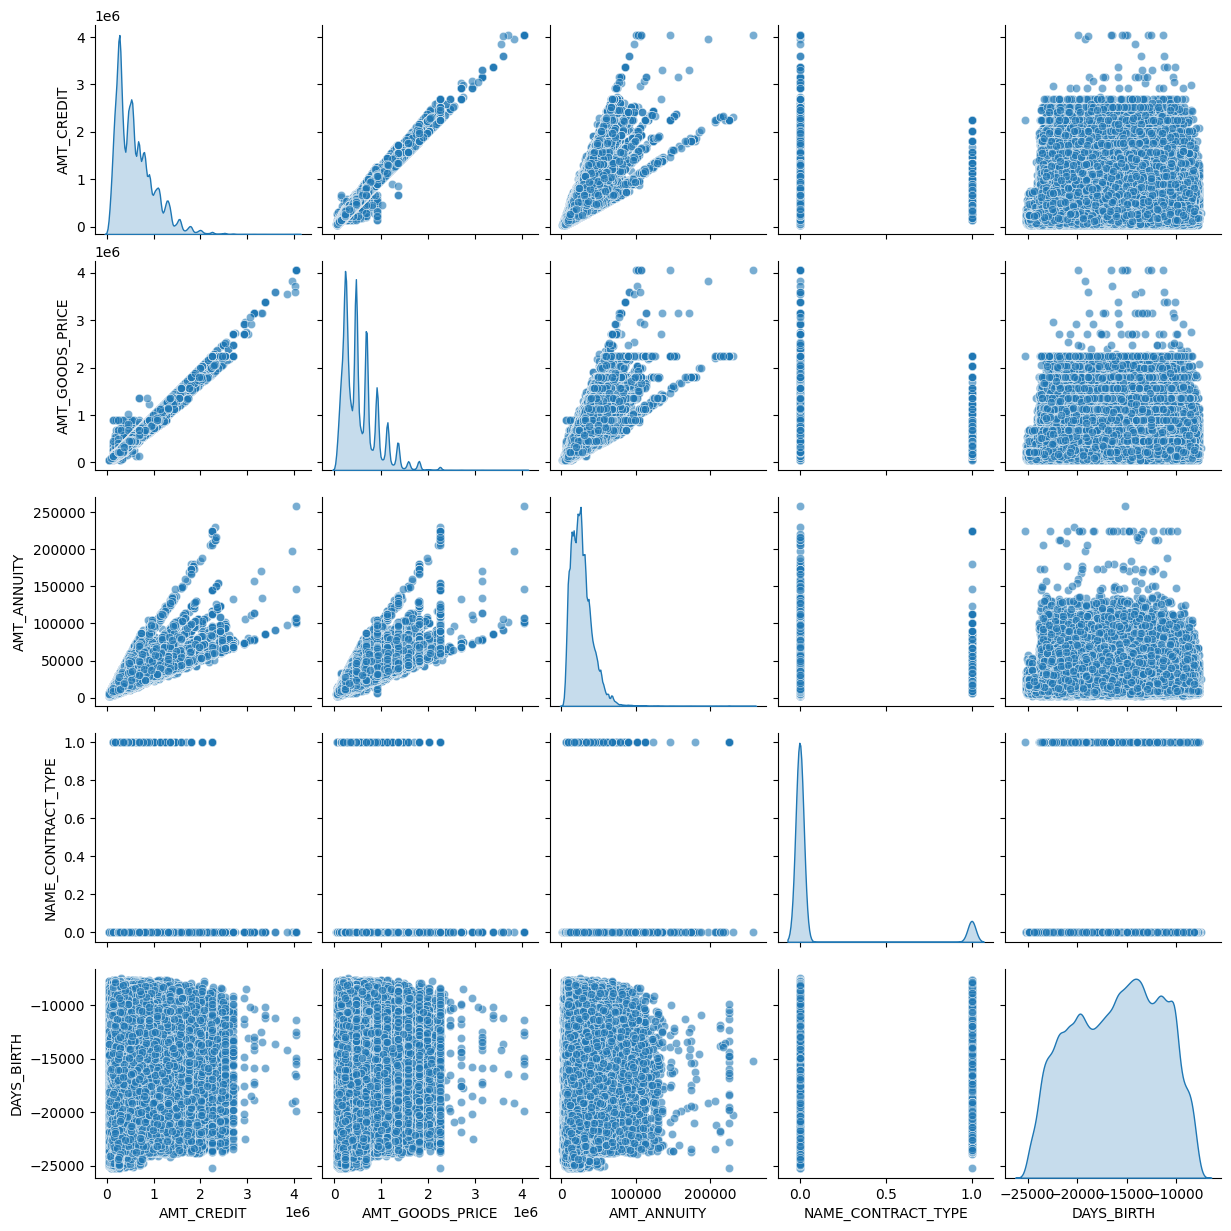

In [7]:
data_pairplot = app_data[['AMT_CREDIT','AMT_GOODS_PRICE','AMT_ANNUITY','NAME_CONTRACT_TYPE','DAYS_BIRTH']]

sns.pairplot(data_pairplot, diag_kind='kde', plot_kws={'alpha': 0.6})
plt.show()

# Outliers zoeken.

Nu we een oke beeld hebben van welke features handig zijn om te gebruiken. is het nu zaak om te zoeken of deze featuers vreemde waardes bevatten of teveel af wijkend van het hele geheel.

Dit zullen we voornamelijk doen door een paar boxplots te maken en te kijken wat die ons vertellen.

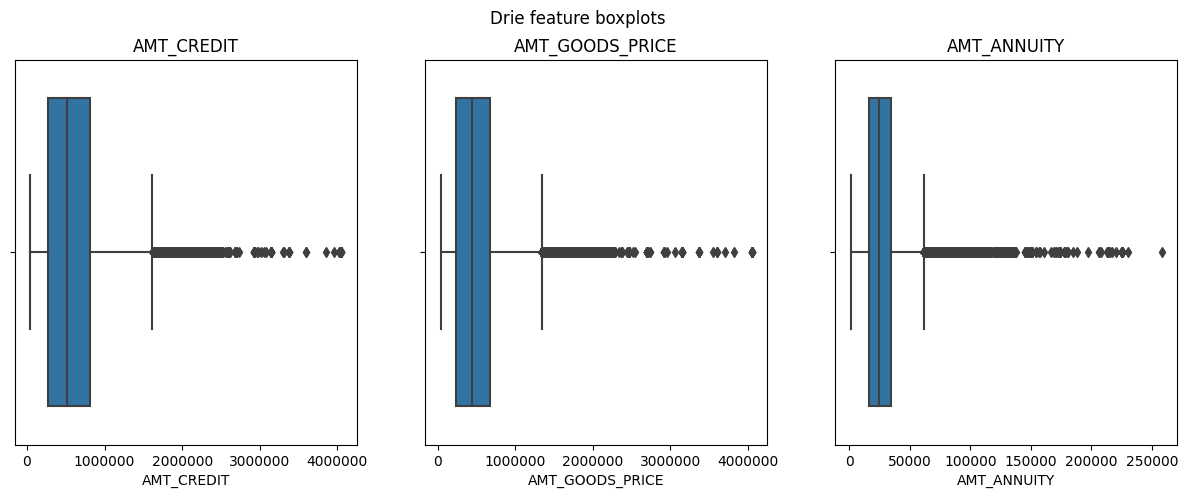

In [8]:
# Maak een figuur met drie subplots naast elkaar
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Eerste boxplot
sns.boxplot(x=app_data['AMT_CREDIT'], ax=axes[0])
axes[0].set_title('AMT_CREDIT')
axes[0].get_xaxis().get_major_formatter().set_scientific(False)

# Tweede boxplot
sns.boxplot(x=app_data['AMT_GOODS_PRICE'], ax=axes[1])
axes[1].set_title('AMT_GOODS_PRICE')
axes[1].get_xaxis().get_major_formatter().set_scientific(False)

# Derde boxplot
sns.boxplot(x=app_data['AMT_ANNUITY'], ax=axes[2])
axes[2].set_title('AMT_ANNUITY')
axes[2].get_xaxis().get_major_formatter().set_scientific(False)

# voegt een titel toe aan de hele figuur
fig.suptitle('Drie feature boxplots')
plt.show()

### We Kunnen dit ook bekijken in een histogram om te kijken hoe features waardes zijn verdeeld

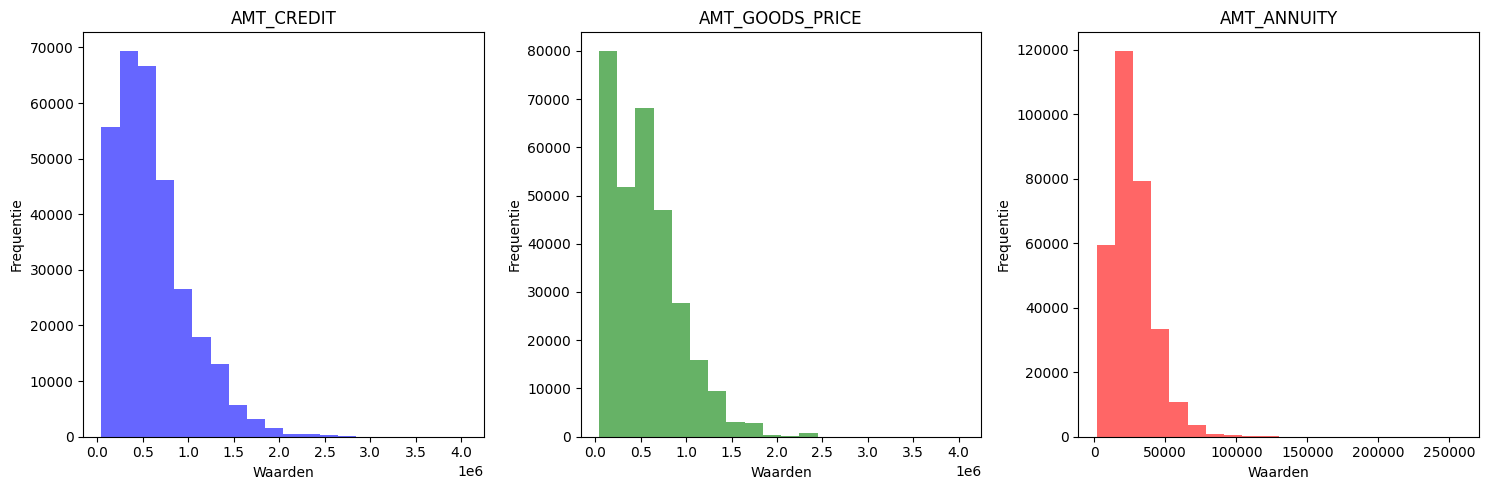

In [9]:
# Maak een figuur met drie subplots naast elkaar
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot het eerste histogram
axes[0].hist(app_data['AMT_CREDIT'], bins=20, color='blue', alpha=0.6)
axes[0].set_xlabel('Waarden')
axes[0].set_ylabel('Frequentie')
axes[0].set_title('AMT_CREDIT')
axes[0].get_xaxis().get_major_formatter().set_scientific(True)

# Plot het tweede histogram
axes[1].hist(app_data['AMT_GOODS_PRICE'], bins=20, color='green', alpha=0.6)
axes[1].set_xlabel('Waarden')
axes[1].set_ylabel('Frequentie')
axes[1].set_title('AMT_GOODS_PRICE')
axes[1].get_xaxis().get_major_formatter().set_scientific(True)

# Plot het derde histogram
axes[2].hist(app_data['AMT_ANNUITY'], bins=20, color='red', alpha=0.6)
axes[2].set_xlabel('Waarden')
axes[2].set_ylabel('Frequentie')
axes[2].set_title('AMT_ANNUITY')
axes[2].get_xaxis().get_major_formatter().set_scientific(True)
# Pas de afstand tussen subplots aan
plt.tight_layout()
plt.show()

Als we kijken naar de boxplots en histograms, valt het meteen dat elke Feature zijn eigen uitschieters heeft. Op zich is er een dikke lijn buiten de whiskers te zien. Alleen nu is de vraag willen we die meenemen in ons model ?

een redelijke manier om dit te bepalen is hoe veel data punten dit daadwerkelijk zijn. In vergelijking tot de volledige data set. Dus laten we kijken hoeveel dat zijn.

In [10]:
AMT_CREDIT = len(app_data[app_data['AMT_CREDIT'] > 1800000])

print(f"Aantal waarden groter dan 1.8 miljoen: {AMT_CREDIT}")

AMT_GOODS_PRICE = len(app_data[app_data['AMT_GOODS_PRICE'] > 2000000])

print(f"Aantal waarden groter dan 2 miljoen: {AMT_GOODS_PRICE}")

AMT_ANNUITY = len(app_data[app_data['AMT_ANNUITY'] > 80000])

print(f"Aantal waarden groter dan 80 duizend: {AMT_ANNUITY}")

Total_Length_Data = len(app_data['AMT_CREDIT'])

print(f"Totale aantal rows in dataset: {Total_Length_Data}")

Aantal waarden groter dan 1.8 miljoen: 3279
Aantal waarden groter dan 2 miljoen: 1093
Aantal waarden groter dan 80 duizend: 1523
Totale aantal rows in dataset: 307511


#### Als we kijken naar de resultaten van de 3 simple check. Is dit te overwegen om ze er uit te halen.

In vergelijking met de 300.000 regels aan data is er 3.000 er van afhalen niet een extreem verlies. En dan bestaat er ook de kans dat die niet eens anderen regels weg haalt van AMT_GOODS_PRICE en AMT_ANNUITY. Aangezien de kans groot is dat die in de zelfde regels vallen als de 3.000 regels

##### Of

we vervangen de grote uitschieters door het gemiddelde van de features om zo te voorkomen dat we regels weg gooien

#### We kiezen natuurlijk voor het vervangen door het gemiddelde ! Want het is zonde om de hele regels eruit te halen

Na dat dit is getest bleek dit niet voor een betere clustering te zorgen. Dit is hierbij verwijderd

### We zullen kijken naar de mogelijkheden met de Kmeans en de GMM

Dit om de 2 modellen met de verschillende features onderling te vergelijken.

In [11]:
# We maken hier alvast de 2 moddelen aan.
kmeans = KMeans()
gmm = GaussianMixture()

#### Kmeans Model voor AMT_CREDIT en AMT_GOODS_PRICE

#### Voordat we een kMeans model kunnen maken moeten we de gegevens normaliseren.

#### Dit is omdat we met een model met afstanden werken, En we willen voorkomen dat bepaalde gegevens meer gewicht gaan hebben in ons model.

#### Hier onder normaliseren we de data

In [12]:
# normalize the AMT_CREDIT and AMT_GOODS_PRICE using the zscore
columns = ['AMT_CREDIT','AMT_GOODS_PRICE']
for col in columns:
    app_data[f'{col}_NORM'] = (app_data[col]-app_data[col].mean())/app_data[col].std()

### Maak het model

In [13]:
# assign used values to X
X = app_data[['AMT_CREDIT','AMT_GOODS_PRICE']]

# Omdat we te maken hebben met sommige missende waardes zullen we deze vullen met de gemiddeldes om dit te verhelpen.
imputer = SimpleImputer(strategy='mean')

X = imputer.fit_transform(X)

# setup possible params
param_grid = {
    'n_clusters': [n for n in range(1, 8)],  # You can adjust the range as needed
}

In [14]:
# create a grid search
grid_search = GridSearchCV(estimator=kmeans, param_grid=param_grid, cv=5)
grid_search.fit(X)

# get the result from the grid search
best_params = grid_search.best_params_
best_n_clusters = best_params['n_clusters']
print(f"The best parameters found from the grid search were n_clusters = {best_n_clusters}")

  File "C:\Users\pepij\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


The best parameters found from the grid search were n_clusters = 7


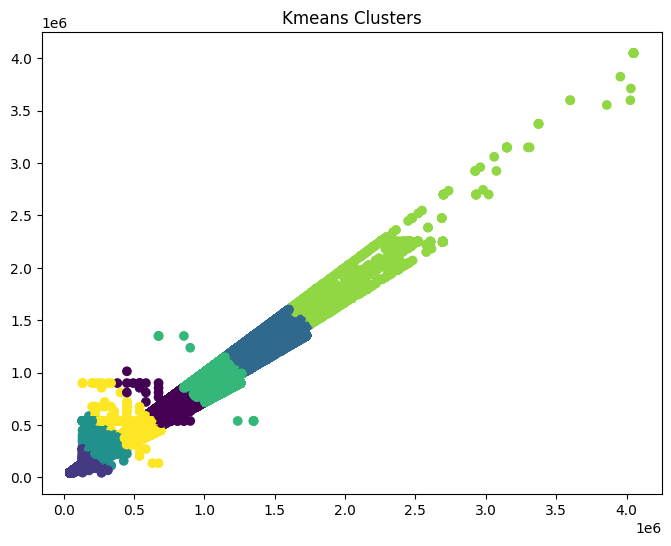

In [15]:
# Set hyper parameters
kmeans.set_params(n_clusters=best_n_clusters)

# Fit het model
kmeans.fit(X)

clusters = kmeans.predict(X)

# Scatterplot maken
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap='viridis')
plt.title('Kmeans Clusters')

plt.show()

##### Nu doen we de zelfde stappen voor het GMM model

In [16]:
X = app_data[['AMT_CREDIT','AMT_GOODS_PRICE']]
# Omdat we te maken hebben met zommige missende waardes zullen we deze vullen met de gemiddeldes om dit te verhelpen.
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

param_grid = {
    'n_components': [n for n in range(1, 8)],  # Het aantal componenten (clusters) in het GMM-model
    'covariance_type': ['full', 'tied'],  # Het type covariantie
}

In [17]:
# create a grid search
grid_search = GridSearchCV(estimator=gmm, param_grid=param_grid, cv=5)
grid_search.fit(X)

# get the result from the grid search
best_params = grid_search.best_params_
best_n_components = best_params['n_components']
best_covariance_type = best_params['covariance_type']
print(f"The best parameters found from the grid search were Ncomponents = {best_n_components} and covariance = {best_covariance_type}")

The best parameters found from the grid search were Ncomponents = 5 and covariance = full


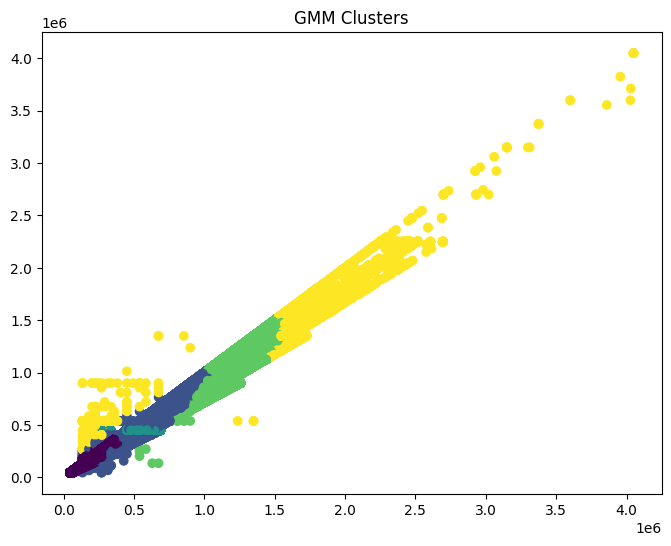

In [18]:
# Set hyper parameters
gmm.set_params(n_components=best_n_components, covariance_type=best_covariance_type, random_state=42)
# We fitten het model met de data.
gmm.fit(X)

# Voer de clustering uit op zowel de daataset
clusters = gmm.predict(X)

# Maak een scatterplot
plt.figure(figsize=(8, 6))

plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap='viridis')
plt.title('GMM Clusters')
plt.show()

#### Nu gaan we het volgende pakken

#### Kmeans Model voor AMT_ANNUITY en AMT_GOODS_PRICE

#### Voordat we een kmeans kunnen maken moeten we de gegevens normaliseren.

#### Dit is omdat we met een model met afstanden werken, En we willen voorkomen dat bepaalde gegevens meer gewicht gaan hebben in ons model.

#### Hier onder normaliseren we de data

In [19]:
# normalize the AMT_CREDIT and AMT_GOODS_PRICE using the zscore
columns = ['AMT_ANNUITY','AMT_GOODS_PRICE']
for col in columns:
    app_data[f'{col}_NORM'] = (app_data[col]-app_data[col].mean())/app_data[col].std()

In [20]:
# assign used values to X
X = app_data[['AMT_ANNUITY','AMT_GOODS_PRICE']]

# Omdat we te maken hebben met zommige missende waardes zullen we deze vullen met de gemiddeldes om dit te verhelpen.
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# setup possible params
param_grid = {
    'n_clusters': [n for n in range(1, 8)],  # You can adjust the range as needed
}

In [21]:
# create a grid search
grid_search = GridSearchCV(estimator=kmeans, param_grid=param_grid, cv=5)
grid_search.fit(X)

# get the result from the grid search
best_params = grid_search.best_params_
best_n_clusters = best_params['n_clusters']
print(f"The best parameters found from the grid search were n_clusters = {best_n_clusters}")

The best parameters found from the grid search were n_clusters = 7


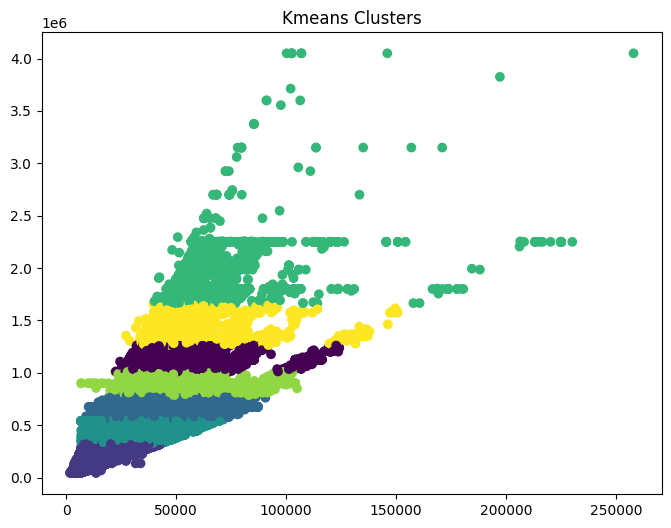

In [22]:
# Set hyper parameters
kmeans.set_params(n_clusters=best_n_clusters)

# Fit het model
kmeans.fit(X)

clusters = kmeans.predict(X)

# Scatterplot
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap='viridis')
plt.title('Kmeans Clusters')
plt.show()

#### Nu Doen we de zelfde stappen voor het GMM model

In [23]:
X = app_data[['AMT_ANNUITY','AMT_GOODS_PRICE']]
# Omdat we te maken hebben met zommige missende waardes zullen we deze vullen met de gemiddeldes om dit te verhelpen.
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

param_grid = {
    'n_components': [n for n in range(1, 8)],  # Het aantal componenten (clusters) in het GMM-model
    'covariance_type': ['full', 'tied'],  # Het type covariantie
}

In [24]:
# create a grid search
grid_search = GridSearchCV(estimator=gmm, param_grid=param_grid, cv=5)
grid_search.fit(X)

# get the result from the grid search
best_params = grid_search.best_params_
best_n_components = best_params['n_components']
best_covariance_type = best_params['covariance_type']
print(f"The best parameters found from the grid search were Ncomponents = {best_n_components} and covariance = {best_covariance_type}")

The best parameters found from the grid search were Ncomponents = 7 and covariance = full


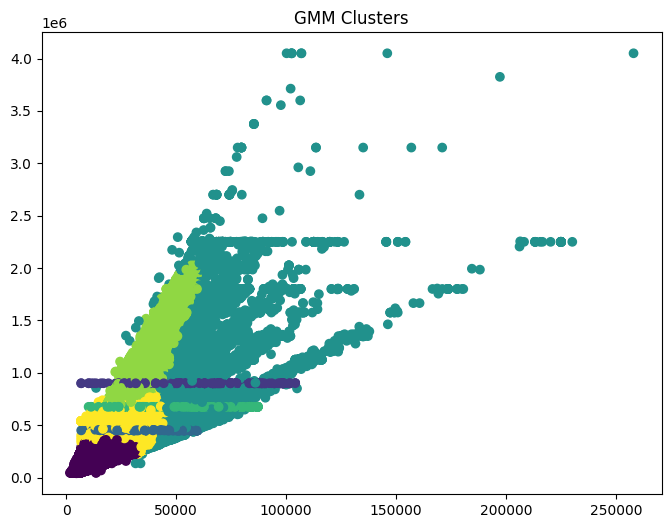

In [25]:
# Set hyper parameters
gmm.set_params(n_components=best_n_components, covariance_type=best_covariance_type, random_state=42)

gmm.fit(X)

# Voer de clustering uit op de dataset
clusters = gmm.predict(X)

# Maak een scatterplot
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap='viridis')
plt.title('GMM Clusters')
plt.show()

## Conclusie onderzoeks vraag 3.

Herhaling Vraag : 
In hoeverre is het mogelijk om logische clusters van consumenten (bijv. AMT_INCOME_TOTAL, DAYS_EMPLOYED, CNT_FAM_MEMBERS) en hun leningen te vinden (bijv. AMT_CREDIT, AMT_ANNUITY, AMT_GOODS_PRICE)? Denk aan consumenten met (te)veel, weinig of geen leningen.

Als we keken naar de correlatie tussen de bepaalde features. Gaf het ons all een richting om te zien welke features nou echt een kans hadden om een goede cluster te vormen.

En na het maken van de modellen op de 2 paren van 2 featurs. 2 Kmeans modellen en GMM modelen en het plotten van de resultaten is het helaas te zien dat er via deze 2 modelen. Geen goede clusters gevonden worden en het allemaal door elkaar blijkt te gaan

Het weghalen van outliers/vervangen door het gemiddelde zorgt hier helaas alleen maar voor een nog slechtere uitkomst, dus dat helpt niet om een beter model te maken.

Dus de uitkomst van het onderzoek is. Dat er geen duidelijke clusters te vinden zijn die echt bruikbaar zijn voor ons doel.